<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 20px; height: 55px">

# Project 3: Reddit NPL Classfication Challenge
Notebook 4: Evaluation and Conclusion

This notebook contains the rationale behind selecting the best model, evaluation and findings for the best model I selected based on notebook 3. Also includes limitations and future studies.

- [Best Model](#Selecting-Best-Model)
- [Evaluation](#Evaluation)
- [Findings](#Findings)
- [Conclusions](#Conclusions)
- [Limitations & Future Studies](#Limitation-&-Future-Studies)



In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn import metrics
import pickle

In [2]:
df = pd.read_csv('../data/combined_for_npl.csv')

pd.set_option('display.max_colwidth', 0)
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

In [3]:
df.head()

,subreddit,text
0,Jokes,"A woman visited a doctor „Kiss me!“ She said.\n„No!“ The doctor replied, „that would be unprofessional.“\nBut the woman insisted: „Please just kiss me! Just once, please!“\nBut the doctor did not give in: „I already told you, that would be unprofessional, and if i think about it, we shouldn’t be having sex either!“"
1,Jokes,Spider-man must be high all the time... Since he likes mary jane so much.
2,Jokes,"An old man walks into the barbershop for a shave and a haircut He asks the barber, ""do you think you can get all my whiskers off? My cheeks are so wrinkled from age"". \n\nThe barber gets a little wooden ball from a cup on the shelf and tells him to put it inside his cheek to spread out the skin. \n\nWhen he's finished, the old man tells the barber that was the cleanest shave he's had in years. But he wanted to know what would have happened if he had swallowed that little ball. \n\nThe barber replied, ""Just bring it back tomorrow like everyone else does""."
3,Jokes,"I remember being a kid and my parents filling my head with nonsense like the Santa, Tooth fairy and Easter Bunny Well now that I'm older I don't fall for that rubbish anymore, thank God."
4,Jokes,"Jesus can walk on water, babies are 72% water, I can walk on babies therefore I am 72% Jesus I’m also 100% in jail"


In [4]:
df.subreddit = df.subreddit.map({'Jokes': 1,
                                'TalesFromRetail': 0})

In [5]:
X = df['text']
y = df['subreddit']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42, stratify = y)

In [6]:
def get_matrix(X_test, y_test, model):
    preds = model.predict(X_test)
    tn, fp, fn, tp = metrics.confusion_matrix(y_test, preds).ravel()
    sensitivity = tp/ (tp + fn)
    specificity = tn/ (tn + fp)
    precision = tp/ (tp + fp)
    print(f'Sensitivity: {sensitivity}')
    print(f'Specificity: {specificity}')
    print(f'Precision: {precision}')
    return metrics.plot_confusion_matrix(model, X_test, y_test, values_format = 'd');

### Selecting Best Model

As my problem statement sets out to explore adding personal touch to virtual assistant, one thing we would like to avoid would be -- while the user is compalining about their experience only to find that the virtual assitant thinks its funny. Certainly, it would also not be too pleasant either if the user is trying to tell a joke and the computer doesn't get it. However it won't hurt one's feeling as much as the former situation. So when I strive for high accuracy, I would also want to optimize for false positive. 

With that in mind, as well as factoring in the number of features needed, computational costs, I have picked Model 2 -- Logistic Regression with TfidfVectorizer as my best model.

### Evaluation

In [7]:
# pickle the model
pickled = pickle.load(open('../assets/logreg_2.pkl', 'rb'))
pickled.score(X_test, y_test)

0.984595906309348

Sensitivity: 0.9857202855942881
Specificity: 0.9834605597964376
Precision: 0.9836546521374686


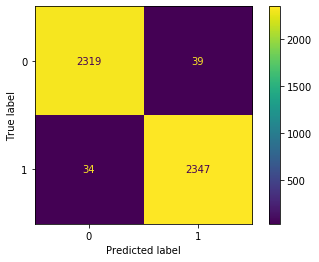

In [8]:
# plot confusion matrix
get_matrix(X_test, y_test, pickled)
plt.savefig('../charts/confusion_metrics.png');

As indicated by the confusion matrix above, the best model has a score of 98.5% in accuracy, 98.6% in sensitivity, 98.3% in specificity and 98.4% in precision. Compared to the baseline model(50.24%), the model has increased the result significantly. 

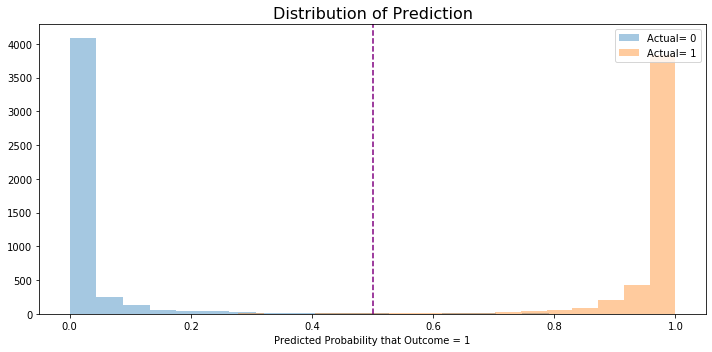

In [9]:
# plot distribution of predictions
# credit to Noelle's classification metrics II lecture notes

res_1 = pd.DataFrame({'true': y_test,
                      'pred_prob': pickled.predict_proba(X_test)[:, 1]})

plt.figure(figsize = (10, 5))

for group in res_1.groupby('true'):
    sns.distplot(group[1], kde = False, bins = 20, label = f'Actual= {group[0]}')

plt.axvline(0.5, color = 'purple', linestyle = '--')   

plt.xlabel('Predicted Probability that Outcome = 1')
plt.title('Distribution of Prediction', fontsize = 16)
plt.legend()
plt.tight_layout()
plt.savefig('../charts/dist_of_pred');  

The above chart shows the distribution of the predictions of the model. With the threshold of 50%, posts to the left are predicted from tales from retail while to the right from jokes. The prediction looks a little polarized with few overlaps, which means the two classes are likely to be very different from each other, from the text perspective.

AUC score: 0.9845904226953629


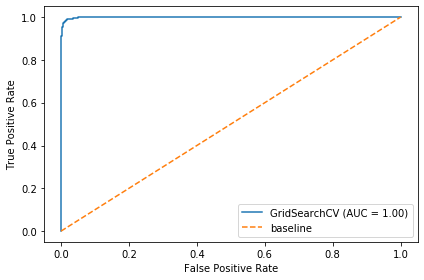

In [10]:
# plot receiver operating character curve and the area under curve
metrics.plot_roc_curve(pickled, X_test, y_test)

plt.plot([0, 1], [0, 1], label = 'baseline', linestyle = '--')

plt.legend()
plt.tight_layout()
plt.savefig('../charts/roc_auc');

print(f'AUC score: {metrics.roc_auc_score(y_test, pickled.predict(X_test))}')

The above ROC chart is a supplement to the confusion matrix indicating how the sensitivity and specificity would change over various threshold. As I would like to optimize for specificity, I would like to go to the left upper corner as much as possible. The model currently already has a great specificity rate. To decrease it even more, the sensitivity would need to go down, which may lead to a decrease in accuracy.

### Findings

This section will revolve around two areas: 
1) misclassified results with a goal to analyze and identify possible future improvements in the model; 
2) significant features in the classification.

### Misclassifications

There are 73 misclassifications in the testing data with 39 as false positive and 34 as false negative. Since the number is not too great, I decided to look into one by one, with the attempt to figure out the possible pattern of misclassification, which will serve as valuable insights to improve the model down the way. I also decided to use sentiment analysis as a tool to help me understand from the perspective of the computer.

In [11]:
# create a dataframe to list all the predictions and actual values

result = pd.DataFrame({'text': X_test,
                      'actual': y_test,
                      'predict': pickled.predict(X_test),
                      'predict_prob': pickled.predict_proba(X_test)[:, 1]})

# find the misclassified predictions

misclassified = result[result['actual']!=result['predict']]

misclassified.to_csv('../data/misclassified.csv', index = False)

In [12]:
# conducting sentiment analysis

from nltk.sentiment.vader import SentimentIntensityAnalyzer

sentiment = SentimentIntensityAnalyzer()

misclassified['sentiment'] = [sentiment.polarity_scores(x)['compound'] for x in misclassified['text']]

def pos_or_neg(sent_score):
    if sent_score > 0:
        return 'positive'
    elif sent_score == 0:
        return 'neutral'
    else:
        return 'negative'

# create a new column to map the function
misclassified['sentiment_cat'] = misclassified['sentiment'].map(pos_or_neg)

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [13]:
# find false positives

fp = misclassified[(misclassified['actual'] == 0) & (misclassified['predict'] == 1)]

# sort by predicted probability

fp.sort_values(by ='predict_prob', ascending = False)

,text,actual,predict,predict_prob,sentiment,sentiment_cat
18071,TFW someone tells you to smile... But you didn't register what they said at first so you just smile in response and regret it immediately for encouraging that gross behavior.,0,1,0.879297,0.0679,positive
14170,"Reverse sexism? My female boss got mad that I asked a female to help move 50 pound boxes of chicken. She claims women are built differently then men, so I should have asked another male. Im a union employee, should I mention this to my union?",0,1,0.877407,-0.2168,negative
17213,Why. I worked at a Walgreens.\n\nA co worker and I suspected that a person was shoplifting so we followed her around the corner.\n\nShe had popped a squat in a dog bed and urinated.\n\nWe asked her why as we kicked her out.\n\nShe said it was because she was on her period.\n\nWHAT,0,1,0.857007,-0.2263,negative
12304,"Salt and Pepper I used to work in a really cool local costume place. It was a seasonal job and one of my favorites.\n\n\nWe had a couple come in (husband was black, wife was white) and start checking out the couple costumes. The wife starts busting up once she sees the salt and pepper costumes, telling her husband ""I should be pepper to really throw people off!"" Her husband overheard me laughing and told me, ""Don't encourage my stupid wife!"" \n\n\nSuch a small moment but one I still remember years later.",0,1,0.833433,0.6616,positive
13285,"Easy Like Sunday Morning Customer: “Will you call me a cab?”\nMe: “Sure! You’re a cab! Who’s next, please?”",0,1,0.805595,0.7464,positive
12235,"Yep half a drop Hi first time poster here.\nI worked in a small pharmacy mainly front of store. When we have out antibiotics we would say to the person how many to take and with or without food ect. \nOne man came in business suit on, carrying a briefcase, wearing sunglasses. \nHis prescription was for eye drops. Took the prescription round got it ready and gave it to the pharmacist to check. \nTook it out to him and went through the normal 1 drop in the infected eye however many times a day ect. \nThis man took his glasses off looked at me and said. \n"" Both eyes are infected. Is that half a drop in each eye? "" \nMe - Umm it's a drop in each eye\nHim - yes but is it a full drop or half a drop\nMe - umm full drop. \nAre people really that thick?",0,1,0.804403,-0.8079,negative
12708,"Got called a fat black bitch for not selling tobacco to some foreigners with no ID. Not going to go too much into detail but basically Asshole A had no ID for his cigar purchase so he asked Asshole B to present his ID. I told him that Asshole A needs to show an ID or I can’t make the sale. Asshole B goes to the car and gets Asshole C who proceeds to show his ID and is told by the other cashier that she can’t take his ID since she witnessed that the purchase was for Asshole A. Long story short, Asshole C starts screaming in my face and telling me I’m a fat, stupid, black bitch.",0,1,0.774534,-0.9638,negative
17082,"Train to Hawaii A bit of a back story, I was a travel agent in Orlando, FL in the 90’s. I loved my job for the most part. I was boggled frequently by people’s lack of geographic knowledge. Onto the quick story.\n\nI had a woman call me up one day inquiring about going to Hawaii. Great! Hawaii is a great destination, lots to see, lots to do and expensive... more commissions for me.\n\nD - ding bat and M - for me\n\nD - I would like to go to Hawaii:\n\nM- Great, where would you like to fly into? Maui, Honolulu?? (Cuts me off)\n\nD- Well first me and my husband are going to drive out to California and then take the train.\n\nM- (a bit confused) Ok, so you are going to drive to California and take a train from where?\n\nD- That’s why I called you! Where does the train leave from in California to Hawaii??\n\nM- Ma’am, there isn’t a train that goes to Hawaii. Hawaii is a group of islands in the Pacific Ocean.\n\nD- Well, I know that! I’m looking at a map the States and Hawaii is just off the coast of Ca

In [32]:
fp['word_count'] = [len(i.split()) for i in fp['text']]
fp.describe()

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,actual,predict,predict_prob,sentiment,word_count
count,39.0,39.0,39.000000,39.000000,39.000000
mean,0.0,1.0,0.663322,0.162954,125.025641
std,0.0,0.0,0.113351,0.730916,74.973500
min,0.0,1.0,0.500915,-0.990700,19.000000
25%,0.0,1.0,0.563890,-0.497200,56.000000
50%,0.0,1.0,0.653166,0.248100,121.000000
75%,0.0,1.0,0.758076,0.845150,174.000000
max,0.0,1.0,0.879297,0.977000,309.000000


In [14]:
fp.sentiment_cat.value_counts()

positive    23
negative    16
Name: sentiment_cat, dtype: int64

23 of the false positive results are identified as having positive sentiment. These are the posts that despite not jokes, that will not alienate users. However for the 16 negative sentiment posts, I found out they are actual rants/complaints about things happen at retail work. These are the ones that more focus should put into to avoid misclassification. The only pattern I noticed based on my observation is that the misclassified data here are relatively shorter.

In [15]:
# find false negatives

fn = misclassified[(misclassified['actual'] == 1) & (misclassified['predict'] == 0)]

# sort by predicted probability

fn.sort_values(by ='predict_prob')

text  \
723   So I went to the store the other day looking for something in paticular. After looking all throughout the store, I could not find it. So I asked an employee if they had it.\n\n"Sorry," he said, "we just sold out."\n\n"You don't have it anymore?" I replied.\n\n"Sorry, we don't have it right now. We do have it Chapter 2 though."                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          

In [31]:
fn['word_count'] = [len(i.split()) for i in fn['text']]
fn.describe()

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,actual,predict,predict_prob,sentiment,word_count
count,34.0,34.0,34.000000,34.000000,34.000000
mean,1.0,0.0,0.361825,0.178744,177.764706
std,0.0,0.0,0.106800,0.649170,237.798751
min,1.0,0.0,0.150823,-0.997000,4.000000
25%,1.0,0.0,0.306224,-0.089925,19.250000
50%,1.0,0.0,0.365476,0.000000,110.500000
75%,1.0,0.0,0.464381,0.910950,226.250000
max,1.0,0.0,0.497996,0.989300,1241.000000


In [16]:
fn.sentiment_cat.value_counts()

positive    16
negative    10
neutral     8 
Name: sentiment_cat, dtype: int64

8 of the false negative predictions have neutral sentiment, which should be a good indicator for jokes, since most tales have stronger emotions. Also for the false negative predictions, many of them somehow contains the retail keywords such as "store", or are in relatively long format, which indicates that the model tends to classify longer texts as from tales from retail.

### Significant Features

Next I would like to look at the significant features that affect the predictions. I listed top 20 most significant features in helping classify each subreddit.

In [17]:
# get all the feature names from the model
features_tvec = pickled.best_estimator_.named_steps['tvec'].get_feature_names()

# get all the coefficients of logistic regression
coef_tvec = pickled.best_estimator_.named_steps['logreg'].coef_[0]

# create a data frame that matches the feature names and coefficients
coef_tvec_df = pd.DataFrame({'features': features_tvec, 
              'coef' : coef_tvec,
              'exp_coef': [np.exp(cf) for cf in coef_tvec]
             })

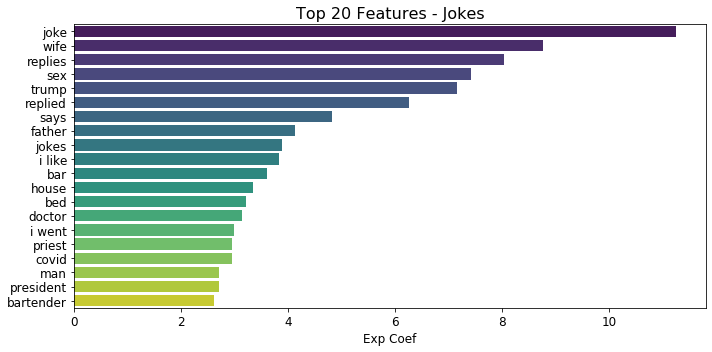

In [18]:
# find and plot top 20 significant feature for Jokes
tvec_top_jokes = coef_tvec_df.sort_values(by = 'exp_coef', ascending = False).head(20)

plt.figure(figsize = (10,5))
sns.barplot(tvec_top_jokes['exp_coef'], tvec_top_jokes['features'], orient = 'h', palette = 'viridis')
plt.yticks(fontsize = 12)
plt.xticks(fontsize = 12)
plt.xlabel('Exp Coef', fontsize = 12)
plt.ylabel('')
plt.title(f'Top 20 Features - Jokes', fontsize = 16)
plt.tight_layout()
plt.savefig('../charts/tvec_1.png');

From the above bar chart, we can see that word "joke" is the most significant feature for jokes subreddit, which is no surprise at all. Interesting pattern however, is that roles/professions account for many in the lists, including: "wife", "father", "doctor", "priest", "bartender", and "president". Second pattern is some potential sexual words, i.e. "sex", "bed", "bar" etc. The third pattern would be more in-trend words, including "trump", and "covid".

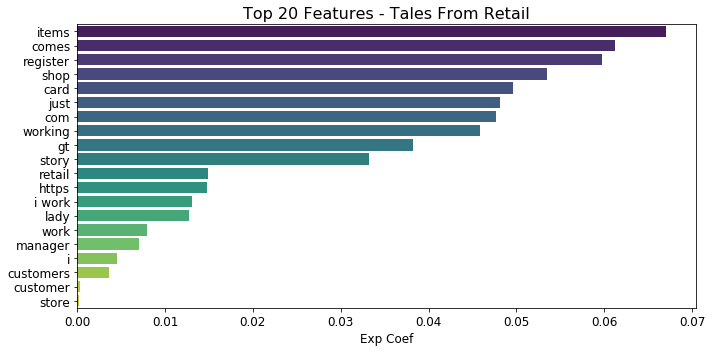

In [19]:
# find and plot top 20 significant feature for TalesfromRetail

tvec_top_tales = coef_tvec_df.sort_values(by = 'exp_coef').head(20)
tvec_top_tales = tvec_top_tales.sort_values(by = 'exp_coef', ascending = False)

plt.figure(figsize = (10,5))
sns.barplot(tvec_top_tales['exp_coef'], tvec_top_tales['features'], orient = 'h', palette = 'viridis')
plt.yticks(fontsize = 12)
plt.xticks(fontsize = 12)
plt.xlabel('Exp Coef', fontsize = 12)
plt.ylabel('')
plt.title(f'Top 20 Features - Tales From Retail', fontsize = 16)
plt.tight_layout()
plt.savefig('../charts/tvec_2.png')

For the significant features in TalesfromRetail, "items" rank first, which makes very much sense, followed by "comes", which also makes sense but does not provide too substantial of meanings. The pattern on this list are mostly retail-related key words, including, "items", "registers", "shop", "card", "retail", "manager", "store", "customer(s)", "manager" and also "i work".

### Conclusions

In conclusion, the logistic regression model vectorized by TfidfVectorizer is the best model for this classification problem. The model has an almost perfect accuracy rate of 98.5% and similar high sensitivity and specificity rate. Besides the fact that I was able to optimize the model to a good extent, it is also likely that the two subreddits are distinctive enough to be classified easily by the model, although in my hypothesis, the two subreddits should be hard to differentiate. In addition, the model also tends to classify based on the length of the texts.

Based on the findings, one of the key identifiers of Jokes are words as professions, as Tales are usually from first person's perspective. Also people tend to make jokes of current events, which could also be a strong indicator of Jokes. Key identifiers of Tales are not surprisingly retail-related terms such as shop, store, customer, manager and register. Notably "I work" is also an important feature as this is usually people tells their own story.

The model could be improved even more if it could decrease classifying posts with negative sentiments as jokes, as this would alienate people's feeling when they are looking for ranting.

### Limitations & Future Studies

Without doubt, there are several limitations of the project. To start with, the data cleaning could be done more thoroughly. In the later stage of the project, I started to realize that there are some https links mixed in the posts, which never occured to me as I was not a Reddit user and was not familiar with its content structure. This results in hyperlink keywords like "https" and "com" show up as significant features in TalesfromRetail. It is also the case with "gt", a format code in html texts which stands for "greater than", which occurs when the text in the post was pasted from somewhere else without reformatting. "gt" also shows up in the top 20 significant features. So for my next step, I would like to focus doing a more thorough data cleaning to increase the legitimacy of posts and thus increasing the model. 

Secondly, the texts were not lemmatized before vectorization, which led to some repetitive features, i.e."customer" and "customers" are both in the top 20 significant features for tales. In my future studies, I would like to explore how to effectively incorporate lemmatize into the pipeline. 

In addition, sentiment analysis seems to be of great help in effectively diminishing the false positive. I would like to explore in the future how to use sentiment analysis as a feature along with the word features in modeling.

Last but not least, one of the target subreddit TalesfromRetail has a strong focus on retail therefore making it easier for the model to classify between two subreddits. However to scale the result, more data other than those from retail should be examined to mitigate the influence of retail terms. 